## Stolen Base Simulation - A Digital Twin Application to Baseball
This notebook uses discrete-event simulation techniques to model a stolen base attempt using 2025 MLB season data sourced from Statcast / Baseball Savant. 

In [16]:
import pandas as pd
from pybaseball import statcast, playerid_lookup, statcast_pitcher, statcast_running, statcast_running_splits
import cv2
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

## Pitcher Data
- The below code uses a CSV extract from the Pitcher Running Game leaderboard on Baseball Savant. Since time to plate (TTP) is not a publicly available metric, we use 'runs_prevented_on_running' as a proxy for a pitcher's ability to manage the run game.
- Pitcher's are split into Elite / Average / Poor tiers based on this statistic, and assigned an estimated TTP sample distribution. 
- Link to Data: https://baseballsavant.mlb.com/leaderboard/pitcher-running-game

In [17]:
# Statcast 2025 Pitcher Running Game Data
pitch_run_df = pd.read_csv('pitcher_running_game.csv')
pitch_run_df.head()

,player_id,player_name,team_name,start_year,end_year,key_target_base,runs_prevented_on_running_attr,n_pitcher_cs_aa,n_init,rate_sbx,n_sb,n_cs,n_pk,n_bk,n_fb,n_plus,n_minus,net_attr_plus,net_attr_minus,r_primary_lead,r_secondary_lead,r_sec_minus_prim_lead,r_primary_lead_sbx,r_secondary_lead_sbx,r_sec_minus_prim_lead_sbx
0,669203,"Burnes, Corbin",AZ,2025,2025,All,-0.299406,-0.092486,336,0.008929,2,1,0,0,1,3,1,-0.240006,-0.558678,11.748818,16.314202,4.565384,11.920667,22.310333,10.389667
1,829272,"Ogasawara, Shinnosuke",WSH,2025,2025,All,-0.046133,-0.050210,226,0.013274,2,1,0,0,0,2,1,0.671445,-0.400938,11.662264,13.988023,2.325759,10.391000,22.861667,12.470667
2,607200,"Fedde, Erick",MIL,2025,2025,All,-1.284502,-0.862420,942,0.027601,24,2,0,0,0,24,2,-9.500197,1.367862,11.566184,16.049396,4.483212,11.659731,24.480308,12.820577
3,664854,"Helsley, Ryan",NYM,2025,2025,All,0.283410,0.441890,412,0.009709,3,1,0,0,0,3,1,1.948365,-0.236140,12.222296,15.094712,2.872416,14.195750,23.587000,9.391250
4,664126,"Fairbanks, Pete",TB,2025,2025,All,-0.241907,0.134576,311,0.022508,5,2,0,0,0,5,2,-2.489144,0.568715,11.890558,16.352173,4.461616,10.976143,22.108000,11.131857


In [19]:
pitch_run_df.sort_values(by='runs_prevented_on_running_attr', ascending=False).head()

,player_id,player_name,team_name,start_year,end_year,key_target_base,runs_prevented_on_running_attr,n_pitcher_cs_aa,n_init,rate_sbx,n_sb,n_cs,n_pk,n_bk,n_fb,n_plus,n_minus,net_attr_plus,net_attr_minus,r_primary_lead,r_secondary_lead,r_sec_minus_prim_lead,r_primary_lead_sbx,r_secondary_lead_sbx,r_sec_minus_prim_lead_sbx
388,571510,"Boyd, Matthew",CHC,2025,2025,All,2.393686,-0.339447,928,0.004310,4,0,5,0,0,4,5,6.763749,2.313190,11.337057,13.213056,1.875999,13.414250,25.429250,12.015000
181,671106,"Allen, Logan",CLE,2025,2025,All,2.136005,1.932260,1064,0.013158,7,7,2,0,0,7,9,5.370212,2.359917,11.504456,13.815309,2.310853,12.074214,20.505571,8.431357
133,701542,"Warren, Will",NYY,2025,2025,All,2.039621,1.567739,965,0.007254,5,2,2,1,0,6,4,5.651047,2.020914,11.758443,15.049214,3.290771,11.834857,20.226429,8.391571
434,607625,"Lugo, Seth",KC,2025,2025,All,1.917837,1.077879,859,0.009313,4,4,3,0,0,4,7,2.967538,2.942955,10.783235,14.500406,3.717171,11.175625,22.462000,11.286375
66,656849,"Peterson, David",NYM,2025,2025,All,1.896102,0.396418,931,0.003222,2,1,3,0,1,3,4,7.643554,0.816424,11.150670,13.639107,2.488438,10.685000,20.324333,9.639333


In [20]:
# Sort by Pitcher Stealing Runs
pitch_run_df = pitch_run_df.sort_values(
    by='runs_prevented_on_running_attr',
    ascending=False
).copy()

# Classify Pitchers via Time to Deliver Estimate
pitch_run_df['ttp_class'] = pd.qcut(
    pitch_run_df['runs_prevented_on_running_attr'],
    q=[0, 0.25, 0.75, 1.0],
    labels=['Slow', 'Average', 'Elite']
)

# TTP Estimates
ttp_map = {
    'Elite':   {'mean': 1.25, 'std': 0.05},
    'Average': {'mean': 1.35, 'std': 0.08},
    'Slow':    {'mean': 1.55, 'std': 0.10}
}

ttp_df = pitch_run_df[['player_name', 'runs_prevented_on_running_attr', 'ttp_class']].copy()

# Build separate maps for mean and std
ttp_mean_map = {k: v['mean'] for k, v in ttp_map.items()}
ttp_std_map  = {k: v['std']  for k, v in ttp_map.items()}

ttp_df['ttp_mean'] = ttp_df['ttp_class'].map(ttp_mean_map).astype(float)
ttp_df['ttp_std']  = ttp_df['ttp_class'].map(ttp_std_map).astype(float)

ttp_df.head()

,player_name,runs_prevented_on_running_attr,ttp_class,ttp_mean,ttp_std
388,"Boyd, Matthew",2.393686,Elite,1.25,0.05
181,"Allen, Logan",2.136005,Elite,1.25,0.05
133,"Warren, Will",2.039621,Elite,1.25,0.05
434,"Lugo, Seth",1.917837,Elite,1.25,0.05
66,"Peterson, David",1.896102,Elite,1.25,0.05


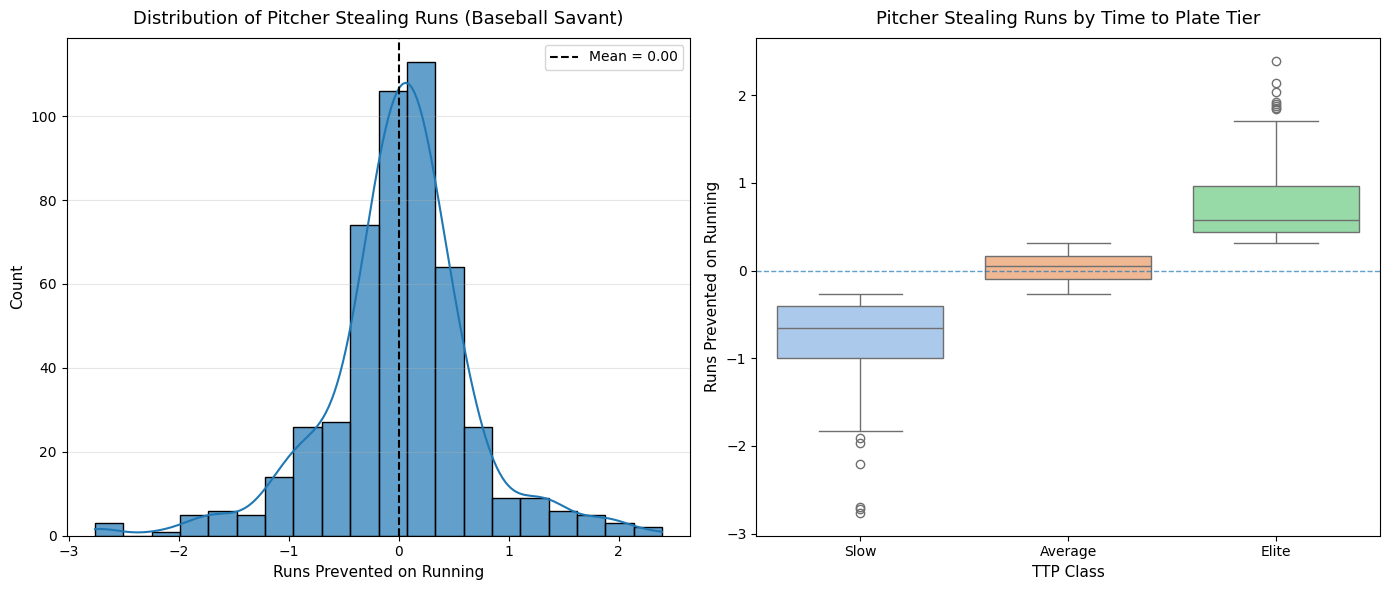

In [21]:
# Pitcher TTP Distribution - boxplot 

pitch_run_df['ttp_class'] = pitch_run_df['ttp_class'].astype('category')

mean_rp = pitch_run_df['runs_prevented_on_running_attr'].mean()

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Runs Prevented on Running Histogram
sns.histplot(
    data=pitch_run_df,
    x='runs_prevented_on_running_attr',
    bins=20,
    kde=True,
    edgecolor="black",
    alpha=0.7,
    ax=axes[0]
)

axes[0].axvline(mean_rp, linestyle="--", linewidth=1.5,
                label=f"Mean = {mean_rp:.2f}", color="black")

axes[0].set_title("Distribution of Pitcher Stealing Runs (Baseball Savant)", fontsize=13, pad=10)
axes[0].set_xlabel("Runs Prevented on Running", fontsize=11)
axes[0].set_ylabel("Count", fontsize=11)
axes[0].grid(axis="y", alpha=0.3)
axes[0].legend()

# Boxplot - Time to Plate Tier
sns.boxplot(
    data=pitch_run_df,
    x='ttp_class',
    y='runs_prevented_on_running_attr',
    palette='pastel',
    hue='ttp_class',
    ax=axes[1]
)

axes[1].axhline(0, linestyle="--", linewidth=1, alpha=0.7)

axes[1].set_title("Pitcher Stealing Runs by Time to Plate Tier", fontsize=13, pad=10)
axes[1].set_xlabel("TTP Class", fontsize=11)
axes[1].set_ylabel("Runs Prevented on Running", fontsize=11)

plt.tight_layout()
plt.show()


## Runner Data
- To calculate a baserunner's service time, we factor in their 90 ft splits and average lead distance, both sourced from Baseball Savant.
- Because 90 ft splits are from home to first on a ball in play, we subtract -.15 seconds from our total service time, assuming the jump on a steal is faster than getting out of the box after a swing.
- Additionally, we calculate total distance required based on the baserunner's average lead distance at pitcher's first move.
- 90ft Splits: https://baseballsavant.mlb.com/leaderboard/running_splits
- Lead at first move: https://baseballsavant.mlb.com/leaderboard/basestealing-run-value

In [22]:
# Run splits via pybaseball
run_splits_df = statcast_running_splits(2025, 5, True)
run_splits_df.head()

,"last_name, first_name",player_id,name_abbrev,team_id,position_name,age,bat_side,seconds_since_hit_000,seconds_since_hit_005,seconds_since_hit_010,seconds_since_hit_015,seconds_since_hit_020,seconds_since_hit_025,seconds_since_hit_030,seconds_since_hit_035,seconds_since_hit_040,seconds_since_hit_045,seconds_since_hit_050,seconds_since_hit_055,seconds_since_hit_060,seconds_since_hit_065,seconds_since_hit_070,seconds_since_hit_075,seconds_since_hit_080,seconds_since_hit_085,seconds_since_hit_090
0,"Abrams, CJ",682928,WSH,120,SS,24,L,0.0,0.53,0.83,1.08,1.31,1.52,1.72,1.92,2.11,2.29,2.47,2.65,2.82,2.99,3.16,3.33,3.51,3.68,3.87
1,"Abreu, Wilyer",677800,BOS,111,RF,26,L,0.0,0.55,0.86,1.12,1.35,1.57,1.77,1.97,2.16,2.34,2.53,2.70,2.88,3.05,3.23,3.40,3.57,3.75,3.94
2,"Acosta, Maximo",691185,MIA,146,3B,22,R,0.0,0.57,0.89,1.16,1.40,1.62,1.83,2.03,2.23,2.41,2.60,2.78,2.95,3.13,3.30,3.47,3.64,3.81,3.99
3,"Acuña Jr., Ronald",660670,ATL,144,RF,27,R,0.0,0.56,0.87,1.12,1.36,1.57,1.78,1.98,2.17,2.35,2.53,2.71,2.89,3.06,3.23,3.40,3.57,3.74,3.92
4,"Acuña, Luisangel",682668,NYM,121,2B,23,R,0.0,0.54,0.84,1.09,1.32,1.53,1.73,1.92,2.10,2.28,2.46,2.63,2.80,2.97,3.13,3.30,3.46,3.63,3.81


In [23]:
# Cleaning DF, Sorting by Fastest at 90 ft
run_splits_df.rename(columns={'last_name, first_name': 'player_name', 'name_abbrev' : 'team_name'}, inplace=True)
run_splits_df[['player_name', 'team_name', 'seconds_since_hit_090']].sort_values(by='seconds_since_hit_090').head()

,player_name,team_name,seconds_since_hit_090
345,"Nuñez, Nasim",WSH,3.67
441,"Simpson, Chandler",TB,3.69
434,"Scott II, Victor",STL,3.71
82,"Carroll, Corbin",AZ,3.73
228,"Johnson, Daniel",BAL,3.76


In [24]:
# Extracted from Statcast 2025 Basestealing Run Value Leaderboard
# URL = https://baseballsavant.mlb.com/leaderboard/basestealing-run-value
# Future Update - scrape programatically / pybaseball
run_val_df = pd.read_csv('basestealing_running_game.csv')
run_val_df.head()

,player_name,year,runner_stealing_runs,net_bases_gained,based_gained_vs_avg,outs_created_vs_avg,sprint_speed,sb_opp,sb_attempt_pct,sb,cs,pk,bk,fb,bases_gained,outs_created,lead_dist_gained_1b_sb_opps,lead_at_first_move_1b,lead_at_rel_1b_sb_opps,lead_dist_gained_1b_sb_att,lead_at_first_move_1b_sb_att,lead_at_rel_1b_sb_att
0,"Simpson, Chandler",2025,3,21,25,-4,29.6,475,7.60%,30,6,0,0,2,32,6,3.0,11.0,14.0,8.7,11.5,20.2
1,"Cruz, Oneil",2025,4,20,22,-2,29.2,366,8.70%,28,4,0,0,0,28,4,3.8,10.9,14.7,7.9,11.3,19.1
2,"Scott II, Victor",2025,3,20,22,-2,30.2,321,9.00%,27,2,2,0,0,27,4,4.5,11.5,16.0,9.7,12.6,22.3
3,"Story, Trevor",2025,4,19,18,1,28.6,428,5.80%,24,1,0,1,0,25,1,3.2,11.5,14.6,11.4,12.2,23.6
4,"Soto, Juan",2025,5,19,15,4,25.8,664,3.90%,26,0,0,0,1,27,0,4.0,10.4,14.4,13.6,14.2,27.9


In [25]:
# remove leading space in player name
run_val_df['player_name'] = run_val_df['player_name'].str.lstrip()

# confirm 
run_val_df[run_val_df['player_name'] == 'Simpson, Chandler']

,player_name,year,runner_stealing_runs,net_bases_gained,based_gained_vs_avg,outs_created_vs_avg,sprint_speed,sb_opp,sb_attempt_pct,sb,cs,pk,bk,fb,bases_gained,outs_created,lead_dist_gained_1b_sb_opps,lead_at_first_move_1b,lead_at_rel_1b_sb_opps,lead_dist_gained_1b_sb_att,lead_at_first_move_1b_sb_att,lead_at_rel_1b_sb_att
0,"Simpson, Chandler",2025,3,21,25,-4,29.6,475,7.60%,30,6,0,0,2,32,6,3.0,11.0,14.0,8.7,11.5,20.2


In [26]:
# Limit to just sprint speed and avg lead at first move
rv_cols = ['player_name', 'sprint_speed', 'lead_at_first_move_1b']
run_val_filt = run_val_df[rv_cols]
print('DF Shape: ', run_val_filt.shape)
run_val_filt.head()

DF Shape:  (326, 3)


,player_name,sprint_speed,lead_at_first_move_1b
0,"Simpson, Chandler",29.6,11.0
1,"Cruz, Oneil",29.2,10.9
2,"Scott II, Victor",30.2,11.5
3,"Story, Trevor",28.6,11.5
4,"Soto, Juan",25.8,10.4


In [28]:
# Merge splits + lead into one dataframe
runner_id = ['player_name', 'team_name']
splits_cols = [col for col in run_splits_df.columns.tolist() if 'seconds_since' in col or col in runner_id]
val_cols = ['player_name', 'sprint_speed', 'lead_at_first_move_1b']

# inner join
runners_df = pd.merge(
    run_splits_df[splits_cols], 
    run_val_filt[val_cols], 
    on='player_name', 
    how='inner'
)


print('Runnders DF Shape: ', runners_df.shape)
runners_df.head()

Runnders DF Shape:  (360, 23)


,player_name,team_name,seconds_since_hit_000,seconds_since_hit_005,seconds_since_hit_010,seconds_since_hit_015,seconds_since_hit_020,seconds_since_hit_025,seconds_since_hit_030,seconds_since_hit_035,seconds_since_hit_040,seconds_since_hit_045,seconds_since_hit_050,seconds_since_hit_055,seconds_since_hit_060,seconds_since_hit_065,seconds_since_hit_070,seconds_since_hit_075,seconds_since_hit_080,seconds_since_hit_085,seconds_since_hit_090,sprint_speed,lead_at_first_move_1b
0,"Abrams, CJ",WSH,0.0,0.53,0.83,1.08,1.31,1.52,1.72,1.92,2.11,2.29,2.47,2.65,2.82,2.99,3.16,3.33,3.51,3.68,3.87,28.2,10.8
1,"Abreu, Wilyer",BOS,0.0,0.55,0.86,1.12,1.35,1.57,1.77,1.97,2.16,2.34,2.53,2.70,2.88,3.05,3.23,3.40,3.57,3.75,3.94,27.6,10.7
2,"Acuña Jr., Ronald",ATL,0.0,0.56,0.87,1.12,1.36,1.57,1.78,1.98,2.17,2.35,2.53,2.71,2.89,3.06,3.23,3.40,3.57,3.74,3.92,27.9,9.4
3,"Acuña, Luisangel",NYM,0.0,0.54,0.84,1.09,1.32,1.53,1.73,1.92,2.10,2.28,2.46,2.63,2.80,2.97,3.13,3.30,3.46,3.63,3.81,29.6,11.7
4,"Adames, Willy",SF,0.0,0.56,0.87,1.14,1.38,1.61,1.82,2.02,2.21,2.40,2.59,2.77,2.95,3.13,3.31,3.48,3.66,3.83,4.01,28.0,11.0


## Catcher Data
- Catcher's service time is simply calculated using average pop time to second base, sourced from Baseball Savant.
- Catchers are again split into three tiers (elite / avg / poor), maintaining their actual avg pop time, but assigning a standard deviation based on tier. The assumption is elite catchers are more consistent, so their pop time variance is lower. 
- Link to data: https://baseballsavant.mlb.com/leaderboard/poptime

In [31]:
# CSV extracted from Baseball Savant
catcher_df = pd.read_csv('poptime.csv')
catcher_df.head()

,entity_name,entity_id,team_id,age,maxeff_arm_2b_3b_sba,exchange_2b_3b_sba,pop_2b_sba_count,pop_2b_sba,pop_2b_cs,pop_2b_sb,pop_3b_sba_count,pop_3b_sba,pop_3b_cs,pop_3b_sb
0,"Sánchez, Gary",596142,110,32,86.8,0.63,9,1.91,1.79,1.92,2,1.46,NaN,1.46
1,"Realmuto, J.T.",592663,143,34,85.2,0.60,50,1.86,1.84,1.86,5,1.42,1.41,1.44
2,"Millas, Drew",686452,120,27,86.3,0.77,6,1.89,1.86,1.90,1,1.60,NaN,1.60
3,"Bailey, Patrick",672275,137,26,84.6,0.60,44,1.86,1.87,1.86,4,1.39,1.43,1.35
4,"Torrens, Luis",620443,121,29,83.8,0.60,29,1.87,1.87,1.86,3,1.38,1.38,1.39


In [32]:
# Add Team Abbrev to Catcher DF via Runner DF
team_lookup = dict(zip(run_splits_df['team_id'], run_splits_df['team_name']))
catcher_df['team_name'] = catcher_df['team_id'].map(team_lookup)
catcher_df[['team_id', 'team_name']].head()

,team_id,team_name
0,110,BAL
1,143,PHI
2,120,WSH
3,137,SF
4,121,NYM


In [33]:
# sort pop time to split into tiers
catcher_df.rename(columns={'entity_name': 'player_name'}, inplace=True)
catcher_df[['player_name', 'team_name', 'pop_2b_sba']].sort_values(by='pop_2b_sba').head()

,player_name,team_name,pop_2b_sba
1,"Realmuto, J.T.",PHI,1.86
3,"Bailey, Patrick",SF,1.86
77,"Rodríguez, Endy",PIT,1.86
4,"Torrens, Luis",NYM,1.87
18,"Haase, Eric",MIL,1.88


In [34]:
# Classify Catchers via Pop time Estimate - For SD Estimate
catcher_df['pop_2b_class'] = pd.qcut(
    catcher_df['pop_2b_sba'], 
    q=[0, 0.25, 0.75, 1.0], 
    labels=['Elite', 'Average', 'Slow']
)

# Pop time SD estimates
poptime_map = {
    'Elite': 0.03,
    'Average': 0.08,
    'Slow': 0.10
}

# Pop Time DF w/ SD + Tier
poptime_df = catcher_df[['player_name', 'team_name', 'pop_2b_sba', 'pop_2b_class']].copy()
poptime_df['pop_2b_std'] = poptime_df['pop_2b_class'].map(poptime_map)

poptime_df['pop_2b_std'] = poptime_df['pop_2b_std'].astype(float)

poptime_cols = ['player_name', 'team_name', 'pop_2b_class', 'pop_2b_sba', 'pop_2b_std']

poptime_df = poptime_df[poptime_cols].copy()
poptime_df.head()

,player_name,team_name,pop_2b_class,pop_2b_sba,pop_2b_std
0,"Sánchez, Gary",BAL,Elite,1.91,0.03
1,"Realmuto, J.T.",PHI,Elite,1.86,0.03
2,"Millas, Drew",WSH,Elite,1.89,0.03
3,"Bailey, Patrick",SF,Elite,1.86,0.03
4,"Torrens, Luis",NYM,Elite,1.87,0.03


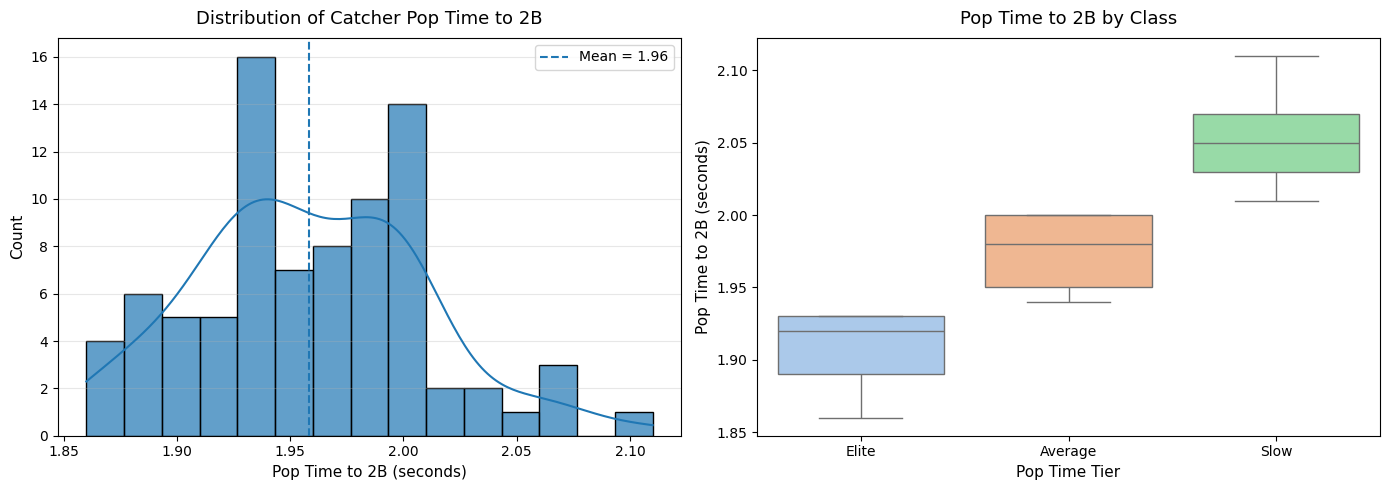

In [35]:
mean_pop = poptime_df['pop_2b_sba'].mean()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Pop time Histogram
sns.histplot(
    data=poptime_df,
    x='pop_2b_sba',
    bins=15,
    kde=True,
    edgecolor="black",
    alpha=0.7,
    ax=axes[0]
)

axes[0].axvline(mean_pop, linestyle="--", linewidth=1.5, label=f"Mean = {mean_pop:.2f}")
axes[0].set_title("Distribution of Catcher Pop Time to 2B", fontsize=13, pad=10)
axes[0].set_xlabel("Pop Time to 2B (seconds)", fontsize=11)
axes[0].set_ylabel("Count", fontsize=11)
axes[0].grid(axis="y", alpha=0.3)
axes[0].legend()

# Pop time Boxplot by Class
sns.boxplot(
    data=poptime_df,
    x='pop_2b_class',
    y='pop_2b_sba',
    palette='pastel',
    hue='pop_2b_class',
    ax=axes[1]
)

axes[1].set_title("Pop Time to 2B by Class", fontsize=13, pad=10)
axes[1].set_xlabel("Pop Time Tier", fontsize=11)
axes[1].set_ylabel("Pop Time to 2B (seconds)", fontsize=11)

plt.tight_layout()
plt.show()

## Simulation - The Stolen Base Attempt
- Here, we execute the stolen base simulation using player statistics and tendencies derived above.
- 'Tag Time' aka the tag application at second is set as a global constant and sampled from a common distribution. Future iterations of this simulation will aim to account for infielders with quicker hands.

In [36]:
# Global Constants 
## Fielder 'Tag Time' - ### Explore Adding Fielder Values in Future
TAG_TIME_MEAN = 0.15      # Avg time for fielder to apply tag
TAG_TIME_STD = 0.05       # Var in tag 

# Runner Reaction Times
# Estimated on 5 foot split speeds as proxy
### future enhancement: input actual mean jump time
def get_runner_reaction_params(seconds_to_5ft):
    """
    Returns (mean, std) for reaction time based on 5ft split speed.
    """
    if pd.isna(seconds_to_5ft):
        return (0.20, 0.05) # Default if data missing
        
    # Elite Burst (Top 25%)
    if seconds_to_5ft < 0.54:
        return (0.18, 0.02)
        
    # Slow Start (Bottom 25%)
    elif seconds_to_5ft > 0.56:
        return (0.24, 0.08)
        
    # Average
    else:
        return (0.20, 0.05)


# Extract Baserunner 0-90 ft splits
def create_splits_dict(runner_row):
    """Extracts columns 'seconds_since_hit_005' through '090'."""
    splits = {}
    for i in range(5, 91, 5):
        col_name = f'seconds_since_hit_{i:03d}'
        if col_name in runner_row and not pd.isna(runner_row[col_name]):
            splits[float(i)] = runner_row[col_name]
    return splits


# Helper Function - Runner Lead Variance
def get_lead_std(avg_lead_distance):
    """Returns the SD based on the runner's average lead strategy."""
    if avg_lead_distance > 12.0:
        return 1.0  
    elif avg_lead_distance < 11.0:
        return 0.3 
    else:
        return 0.5 

# Runner time to second
def get_runner_service_time(runner_row):
    """Calculates total time to reach 2nd base."""
    # Sample Lead Distance 
    avg_lead = runner_row['lead_at_first_move_1b']
    lead_std = get_lead_std(avg_lead)

    sampled_lead_distance = np.random.normal(avg_lead, lead_std)
    
    # 90 ft basepath - lead distance = Distance to 2nd
    distance_needed = 90.0 - sampled_lead_distance

    # 90 ft splits time (0, 5,...90)
    split_dict = create_splits_dict(runner_row)
    
    distances = sorted(split_dict.keys())
    times = [split_dict[d] for d in distances]
    
    # Interpolate time to cover the specific distance
    physical_time = np.interp(distance_needed, distances, times)
    
    # Sample Reaction Time using 5 Ft Split as Proxy
    burst_metric = runner_row['seconds_since_hit_005']
    react_mean, react_std = get_runner_reaction_params(burst_metric)
    reaction = np.random.normal(react_mean, react_std)
    
    # Static Adjustment (Steal Faster than Hit)
    steal_adjustment = -0.15 

    run_time = physical_time + reaction + steal_adjustment 
    
   # return physical_time, reaction, steal_adjustment, run_time
    return run_time

# Pitcher + Catcher + Tag
def get_defense_service_time(pitcher_row, catcher_row):
    """Calculates time for Ball to reach Glove + Tag."""
    
    # Pitcher Delivery
    t_pitch = np.random.normal(pitcher_row['ttp_mean'], pitcher_row['ttp_std'])
    
    # Catcher Pop Time
    t_pop = np.random.normal(catcher_row['pop_2b_sba'], catcher_row['pop_2b_std'])
    
    # Tag Application
    t_tag = np.random.normal(TAG_TIME_MEAN, TAG_TIME_STD)

    t_def = t_pitch + t_pop + t_tag 
    
    return t_def

# Simulation Loop - SB Attempt
def run_stolen_base_simulation(runner_row, pitcher_row, catcher_row, n_sims=10000):
    
    safe_count = 0
    results_log = []
    
    print(f"\n--- SIMULATION MATCHUP ---")
    print(f"Runner:  {runner_row['player_name']} (Lead: {runner_row['lead_at_first_move_1b']}ft | 5ft Burst: {runner_row['seconds_since_hit_005']}s)")
    print(f"Pitcher: {pitcher_row['player_name']} (Avg TTP: {pitcher_row['ttp_mean']}s) | Class: {pitcher_row['ttp_class']})")
    print(f"Catcher: {catcher_row['player_name']} (Avg Pop: {catcher_row['pop_2b_sba']}s | Class: {catcher_row['pop_2b_class']})")
    
    
    for _ in range(n_sims):
        t_offense = get_runner_service_time(runner_row)
        t_defense = get_defense_service_time(pitcher_row, catcher_row)
        
        # Safe / Out
        if t_offense <= t_defense: # Tie to Runner
            safe_count += 1
            
        # Log Results
        results_log.append(t_defense - t_offense)
            
    return safe_count / n_sims, results_log

## Simulation Run + Results
- Below, we can input actual pitcher / catcher / runner combinations to estimate the probability of a successful steal


--- SIMULATION MATCHUP ---
Runner:  Simpson, Chandler (Lead: 11.0ft | 5ft Burst: 0.53s)
Pitcher: Weissert, Greg (Avg TTP: 1.35s) | Class: Average)
Catcher: Wong, Connor (Avg Pop: 1.97s | Class: Average)

DECISION THRESHOLD: 71.3%

PROBABILITY SAFE: 83.5%
DECISION: STEAL IS ON


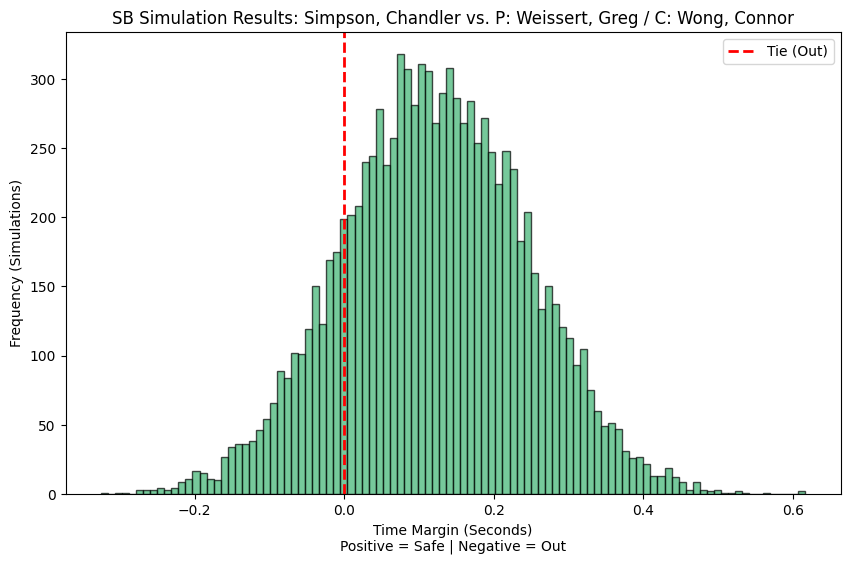

In [39]:
# Select Players
runner_name = "Simpson, Chandler"   
pitcher_name = "Weissert, Greg"   
catcher_name = "Wong, Connor" 

# Can be adjusted based on run environment
success_threshold = .713

# Extract Player Row
try:
    real_runner = runners_df[runners_df['player_name'] == runner_name].iloc[0]
    real_pitcher = ttp_df[ttp_df['player_name'] == pitcher_name].iloc[0]
    real_catcher = poptime_df[poptime_df['player_name'] == catcher_name].iloc[0]

    # Run SB Sim
    prob_safe, history = run_stolen_base_simulation(
        real_runner, 
        real_pitcher, 
        real_catcher, 
        n_sims=10000
    )

    # Results
    print(f"\nDECISION THRESHOLD: {success_threshold*100:.1f}%")
    print(f"\nPROBABILITY SAFE: {prob_safe*100:.1f}%")
    if prob_safe > success_threshold:
        print("DECISION: STEAL IS ON")
    else:
        print("DECISION: NO STEAL")
    
    # Visualization
    plt.figure(figsize=(10, 6))
    plt.hist(history, bins=100, color='mediumseagreen', alpha=0.7, edgecolor='black')
    plt.axvline(0, color='red', linestyle='dashed', linewidth=2, label="Tie (Out)")
    plt.xlabel("Time Margin (Seconds)\nPositive = Safe | Negative = Out")
    plt.ylabel("Frequency (Simulations)")
    plt.title(f"SB Simulation Results: {runner_name} vs. P: {pitcher_name} / C: {catcher_name}")
    plt.legend()
    plt.show()

except IndexError:
    print("ERROR: One or more players not Found.")

## TTP Verification - OpenCV
- While not directly necessary for this simulation, the below code gives an example of how pitcher time to plate estimates were validated.
- Using the OpenCV library and video downloaded from Baseball Savant, we use an example of Spencer Arighetti pitching from the stretch to get a true sample of his TTP.
- Our estimates classified Arighetti as 'Slow', and here, we see this singular example confirms that, with a TTP of 1.756 seconds.

In [25]:
# open video
video_path = "arighetti-test.mp4"
cap = cv2.VideoCapture(video_path)

fps = cap.get(cv2.CAP_PROP_FPS)
print("FPS:", fps)

frame_idx = 0
t_start = None
t_end = None

while True:
    ret, frame = cap.read()
    if not ret:
        break

    # Current time in seconds from frame idx
    t = frame_idx / fps

    # Add Frame Info
    text = f"Frame: {frame_idx}   Time: {t:.3f} s"
    cv2.putText(frame, text, (20, 40),
                cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)

    # Video Navigation
    cv2.imshow("Pitch Video (n=next, 1=start, 2=end, q=quit)", frame)

    # Advance frame w/ key
    key = cv2.waitKey(0) & 0xFF  

    if key == ord('n'):
        # next frame
        frame_idx += 1
        continue
    elif key == ord('1'):
        t_start = t
        print(f"Marked FIRST MOVEMENT at frame {frame_idx}, t = {t_start:.3f} s")
        frame_idx += 1
    elif key == ord('2'):
        t_end = t
        print(f"Marked GLOVE CONTACT at frame {frame_idx}, t = {t_end:.3f} s")
        frame_idx += 1
    elif key == ord('q') or key == 27:  # 'q' or ESC
        break

cap.release()
cv2.destroyAllWindows()

if t_start is not None and t_end is not None:
    print(f"Time to home = {t_end - t_start:.3f} s")
else:
    print("Start and End Not Marked.")

FPS: 59.78708084756223
Marked FIRST MOVEMENT at frame 105, t = 1.756 s
Marked GLOVE CONTACT at frame 210, t = 3.512 s
Time to home = 1.756 s
